# YOLO11 Instance Segmentation Training and Inference Notebook

This notebook is a simple example of how to pull your exported object detection dataset from Oslo and train a YOLO11-Seg model using the Ultralytics library.

You need to have the following information to run this notebook:

- `project_identifier`: The identifier of the project you want to use, you can find this on the project page in Oslo.
- `access_token`: Your personal access token, you can find this in your organization settings in Oslo.
- `version`: The version of the dataset you want to use, you can find this on the exports page in Oslo.

It is a good idea to check that you have GPU available first.



In [1]:
!nvidia-smi

Sun Mar  2 14:28:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8              7W /  165W |    5108MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip3 install -U ultralytics

import ultralytics as ul
ul.checks()

import os

HOME = os.getcwd()
print("HOME:", HOME)

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
Setup complete ✅ (24 CPUs, 30.5 GB RAM, 427.7/767.9 GB disk)
HOME: /home/pyrat/projects/training-notebooks/notebooks


In [ ]:
!pip3 install -U oslovision

from oslovision import OsloVision

project_identifier = "[YOUR_PROJECT_IDENTIFIER]"
access_token = "[YOUR_API_ACCESS_TOKEN]"
dataset_version = "[YOUR_DATASET_VERSION]"

oslo = OsloVision(access_token)

# Download dataset
dataset_path = oslo.download_export(project_identifier, dataset_version, HOME)

print("Dataset path:", dataset_path)

Defaulting to user installation because normal site-packages is not writeable
Dataset path: /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2


# Create a Grid of Multiple Images
Visualize 10 random images from the training set in a grid layout to verify that segmentation masks appear correctly.

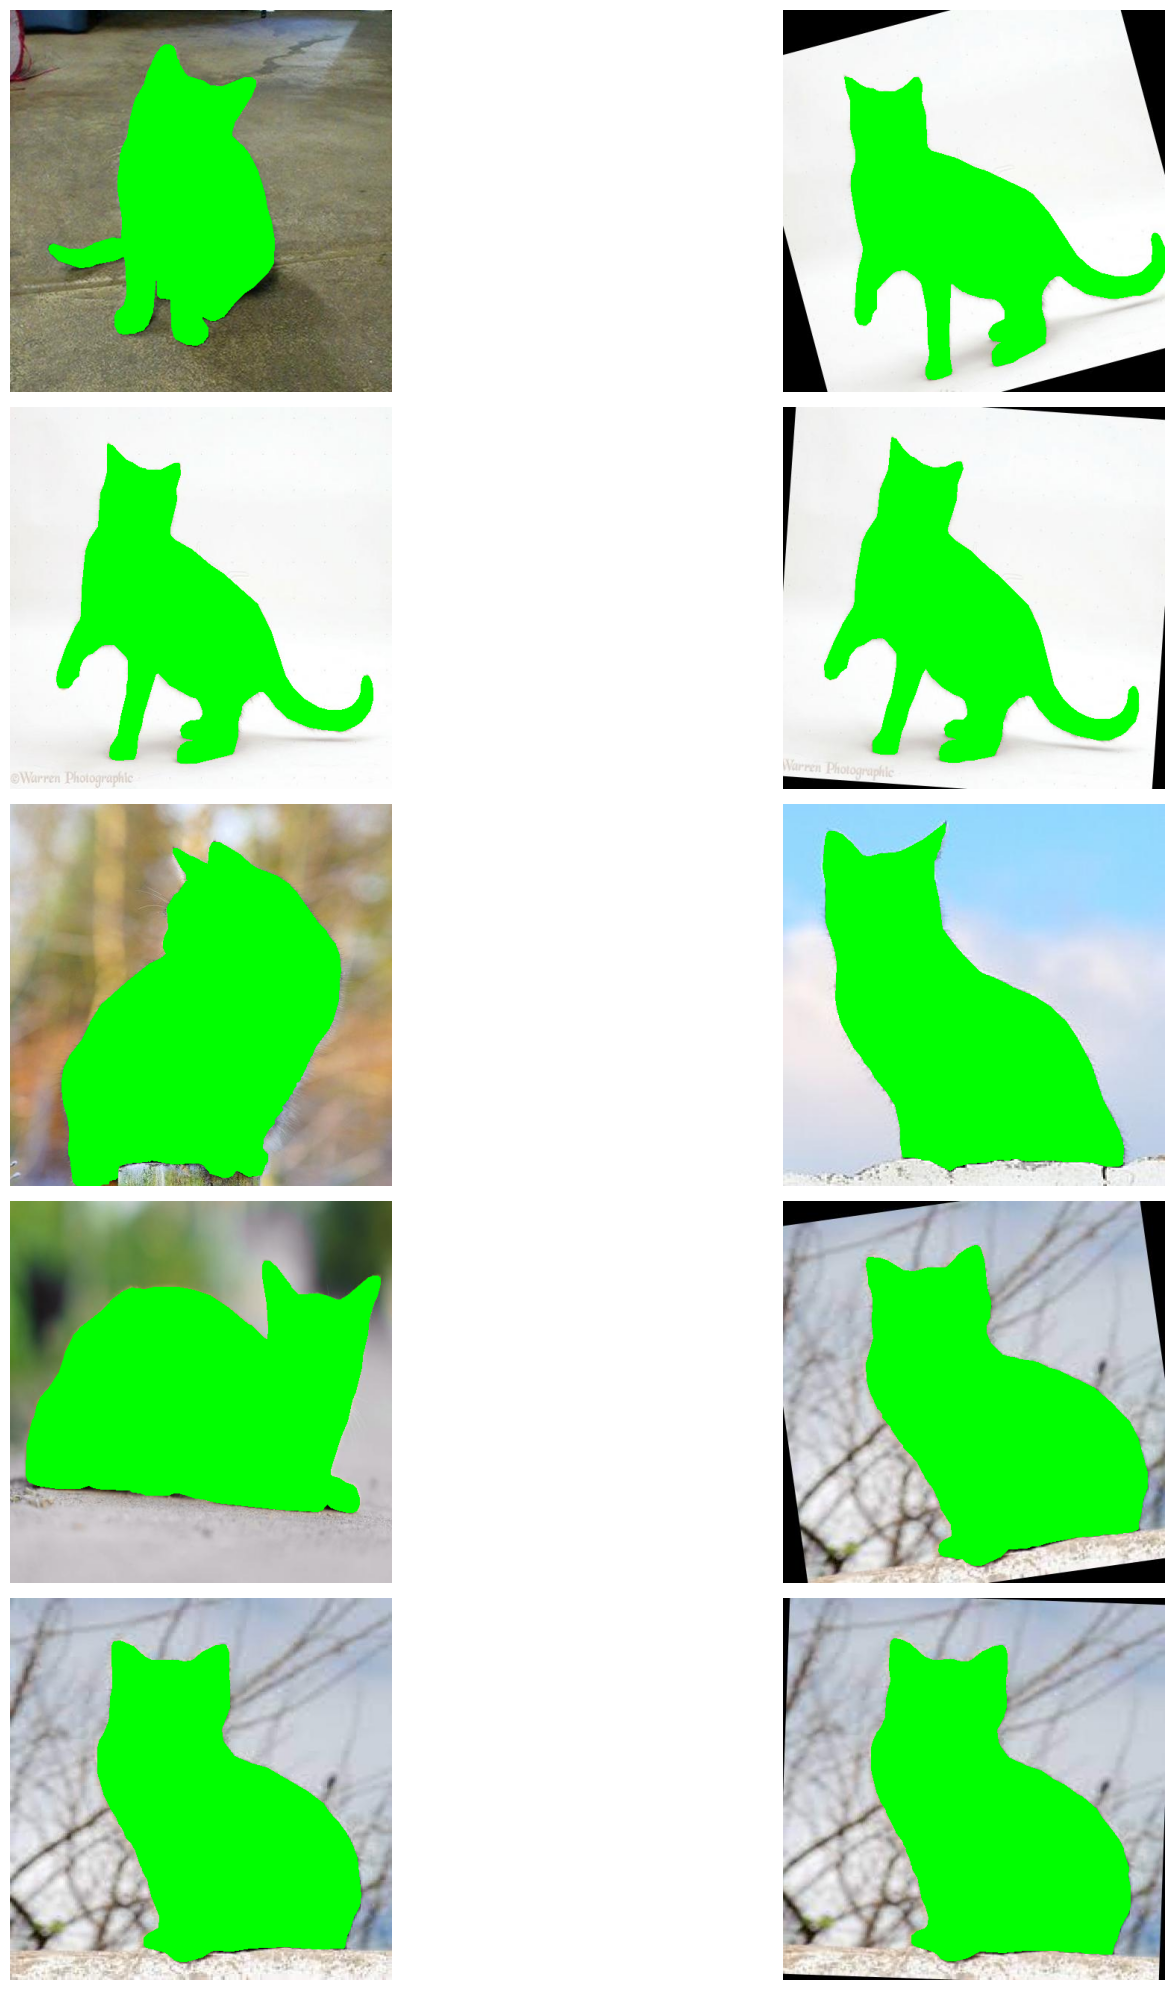

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import yaml
import os

def parse_yolo_segmentation(file_path):
    """
    Parse YOLO segmentation file and return a list of masks.
    """
    masks = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            points = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
            masks.append((class_id, points))
    return masks

def convert_normalized_coordinates(points, img_width, img_height):
    """
    Convert normalized coordinates to absolute pixel values.
    """
    points[:, 0] *= img_width
    points[:, 1] *= img_height
    return points.astype(np.int32)

def draw_masks_on_image(image, masks):
    """
    Draw segmentation masks on the image.
    """
    img_height, img_width = image.shape[:2]
    for class_id, points in masks:
        points = convert_normalized_coordinates(points, img_width, img_height)
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.fillPoly(image, [points], color=(0, 255, 0, 50))
    return image

# Define the path to the dataset and annotations
images_path = '/home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/train/images'
annotations_path = '/home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/train/labels'

# Get a list of image files and corresponding annotation files
image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.jpg')])
annotation_files = sorted([os.path.join(annotations_path, f) for f in os.listdir(annotations_path) if f.endswith('.txt')])

def visualize_images_with_masks(image_files, annotation_files, num_images=10):
    """
    Visualize a specified number of images with their segmentation masks.
    """
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        # Load image
        image = cv2.imread(image_files[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load and parse annotation
        masks = parse_yolo_segmentation(annotation_files[i])
        
        # Draw masks on image
        image_with_masks = draw_masks_on_image(image, masks)
        
        # Display the image with masks in a grid
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_with_masks)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize 10 images with their segmentation masks
visualize_images_with_masks(image_files, annotation_files, num_images=10)

In [6]:
import os

home_dir = os.environ.get("HOME")
print("HOME_DIR:", home_dir)

!rm -rf $home_dir/.config/Ultralytics


HOME_DIR: /home/pyrat


In [7]:
from ultralytics import YOLO
 
model = YOLO('yolo11s-seg.pt')
yaml_path = dataset_path + "/data.yaml"
 
results = model.train(data=yaml_path, epochs=100)


Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

100%|██████████| 755k/755k [00:00<00:00, 13.0MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 19                  -1  1    345472  ultralytics.nn.modules.block.C3k2            [384, 256, 1, False]          
 20                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1   1475065  ultralytics.nn.modules.head.Segment          [3, 32, 128, [128, 256, 512]] 
YOLO11s-seg summary: 203 layers, 10,083,449 parameters, 10,083,433 gradients, 35.6 GFLOPs

Transferred 555/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/train/labels.cache... 516 images, 0 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'



val: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/valid/labels.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.79G       0.72      1.823      2.337      1.208          7        640: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        111        113      0.501      0.412      0.362      0.213      0.477      0.383      0.293      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.87G     0.9665      1.871      1.645      1.358          7        640: 100%|██████████| 33/33 [00:06<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        111        113      0.796     0.0569      0.126     0.0445      0.815      0.065      0.129     0.0527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.85G      1.077      1.974      1.602      1.424         15        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

                   all        111        113      0.352      0.122     0.0177    0.00627      0.014      0.114     0.0127    0.00364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.86G      1.095      1.997      1.491      1.426          7        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113     0.0163     0.0541    0.00686    0.00148     0.0306     0.0911     0.0142    0.00363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.86G      1.068      1.924      1.481      1.402         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.129      0.318      0.104     0.0363       0.15      0.261      0.114     0.0462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100       4.9G      1.046      1.862      1.429      1.403         15        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113      0.486      0.444      0.424      0.217      0.432      0.427      0.365      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.86G      1.026      1.826      1.415      1.389          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all        111        113        0.5      0.535      0.534       0.24      0.362      0.545      0.427        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.86G      1.046      1.773       1.38      1.392         11        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all        111        113      0.317      0.791      0.394      0.199      0.328      0.797      0.424      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.85G     0.9451      1.564       1.33      1.326         15        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        111        113      0.671      0.583      0.639      0.378       0.69      0.586      0.648      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.86G     0.9721      1.666      1.277      1.342         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        111        113      0.635       0.57      0.626      0.383      0.699      0.542      0.662      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.87G     0.9385      1.655      1.307      1.311         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

                   all        111        113      0.707      0.716      0.789      0.525      0.707      0.716      0.783      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.85G     0.8803      1.634      1.223       1.27         13        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        111        113      0.561      0.741      0.676      0.422      0.574      0.754        0.7      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.82G     0.8112      1.485      1.176      1.239          8        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.569      0.743      0.707      0.454      0.584      0.751       0.72      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.86G     0.8065      1.456      1.081      1.225         13        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.651      0.624      0.687      0.442      0.643      0.615      0.659      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.87G     0.8156      1.412      1.144      1.225          7        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        111        113      0.739      0.842      0.887      0.647      0.739      0.842      0.887      0.692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.87G     0.7825      1.402      1.074      1.203         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

                   all        111        113      0.614      0.728      0.733      0.512      0.681      0.663      0.724      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.85G     0.7987      1.448      1.068      1.217         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        111        113       0.67      0.844      0.835      0.579       0.67      0.828      0.826      0.629



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.86G      0.795      1.418       1.04      1.227         14        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113      0.736      0.746      0.779      0.533       0.75      0.755      0.791      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.87G      0.772      1.409      1.038      1.218         13        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113       0.45      0.606      0.524       0.33       0.45      0.613      0.535      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.83G     0.7812      1.321       1.05      1.211          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

                   all        111        113      0.623        0.9       0.84      0.562      0.614       0.89      0.834      0.634



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.82G     0.6977      1.275     0.9882      1.169          9        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.731      0.848      0.866      0.628      0.736      0.856      0.876      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.87G      0.726      1.266     0.9849      1.179         14        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.685      0.705      0.697      0.508      0.677      0.698      0.695      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.84G     0.7552      1.188      0.975      1.197         12        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113      0.824      0.683      0.836      0.581      0.845        0.7      0.866      0.601



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.88G     0.7804       1.37      1.032       1.21          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        111        113      0.836      0.847       0.92      0.704      0.836      0.847      0.927      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       4.8G     0.7151      1.201     0.9614      1.179          8        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.629      0.867      0.857      0.607      0.629      0.867      0.858      0.681



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.86G     0.7114      1.306      1.008      1.185          6        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        111        113      0.759      0.894      0.902      0.659      0.754      0.886      0.899      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.85G     0.6765      1.223     0.9153      1.153         11        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        111        113      0.878      0.842      0.924      0.714      0.888      0.851      0.926      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.86G     0.6723      1.209     0.9181      1.158         13        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        111        113      0.795      0.915      0.922      0.726      0.801      0.923      0.935      0.753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.82G     0.6888      1.181     0.8922      1.161          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        111        113      0.738      0.819      0.857      0.654      0.735       0.82      0.851      0.657



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.83G     0.6474       1.13     0.8429      1.115         10        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.837      0.816      0.914      0.704      0.858      0.832       0.93      0.727



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.86G     0.6423      1.189     0.8429      1.136         12        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.953      0.884      0.978      0.765      0.955      0.874      0.972      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.88G     0.6121      1.118     0.8149      1.108         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

                   all        111        113      0.888      0.906      0.971      0.763      0.888      0.906      0.971      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.84G     0.6561      1.148     0.8593      1.138         10        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.878      0.852      0.958      0.748      0.878      0.852      0.958       0.81



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.85G     0.6178      1.086     0.7979      1.108         11        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.865      0.902      0.942      0.749       0.88      0.919      0.954      0.796



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.85G     0.6121      1.102     0.8615      1.097         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        111        113      0.925      0.865      0.948      0.773       0.95      0.889      0.968      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.87G     0.6086      1.127     0.7817      1.122         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        111        113      0.861      0.918      0.948      0.759      0.861      0.918      0.949      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.82G     0.6249        1.1     0.7704      1.111          9        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.889      0.904      0.936      0.747      0.889      0.904      0.936      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.87G     0.6016      1.091     0.7889      1.111          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113      0.927      0.943      0.966      0.813      0.915      0.935      0.966      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.84G     0.5892      1.071     0.7597      1.103          6        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.897      0.928      0.969      0.798      0.897      0.928      0.969      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.86G     0.5998      1.122     0.7878      1.115          6        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

                   all        111        113      0.915      0.898      0.966      0.794      0.915      0.898      0.966      0.857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.82G     0.5929      1.054     0.7877        1.1          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113      0.936      0.881      0.969      0.771      0.936      0.881      0.969      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.86G     0.5819     0.9862     0.7633      1.092         14        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.917      0.887      0.972      0.795      0.917      0.887      0.969      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.86G     0.5586      1.019      0.746      1.074         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113       0.93      0.912      0.975      0.793       0.93      0.912      0.975      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.91G     0.5807       1.03     0.7329      1.078         14        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        111        113      0.879      0.943      0.962      0.808      0.879      0.943      0.962      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.84G     0.5567      0.973     0.7148      1.082          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113       0.85      0.898      0.951      0.814       0.85      0.898      0.951      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.85G     0.5589      1.017     0.6961      1.068          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113       0.96      0.936      0.983      0.819       0.96      0.936      0.983       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.89G     0.5626     0.9983      0.732      1.083          6        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.939      0.976      0.987      0.861      0.939      0.976      0.987       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.83G     0.5165     0.9307     0.6557      1.044          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.901      0.904      0.975      0.806      0.901      0.904      0.975      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.82G     0.5451     0.9253     0.6842      1.075          8        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.945      0.966      0.987      0.818      0.945      0.966      0.987      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.86G     0.5413     0.9699     0.6749      1.073          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.873      0.927      0.974       0.85      0.873      0.927      0.974      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.84G     0.5146     0.8989     0.6708      1.051          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113      0.888      0.905      0.949      0.825      0.914      0.933       0.98      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.85G     0.5213     0.9311     0.6988      1.068         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.876      0.909      0.965      0.811      0.883      0.918      0.969       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.84G     0.5263     0.9533     0.6978      1.064         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        111        113      0.976      0.937      0.989      0.868      0.976      0.937      0.989      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.85G     0.4992     0.8915     0.6597      1.045         10        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.949      0.963      0.982       0.87      0.949      0.963      0.982      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.88G     0.5149     0.9849      0.669      1.056         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.915      0.904      0.967      0.843      0.915      0.904      0.967       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.85G     0.5166     0.9093     0.6488      1.058         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.932      0.963      0.978      0.857      0.932      0.963      0.978      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.81G      0.498     0.8928     0.6394      1.053         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.946       0.93      0.987      0.866      0.946       0.93      0.987      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.86G     0.5255     0.8898     0.6437      1.073         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113      0.922      0.876      0.954      0.836      0.922      0.876      0.956      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.88G     0.5108     0.8781      0.632       1.05         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        111        113      0.965      0.959      0.983      0.854      0.965      0.959      0.983      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.85G     0.4948     0.8035     0.5871      1.038          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        111        113      0.932      0.957      0.977      0.858       0.94      0.962       0.98       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.82G     0.4769     0.8566     0.6029      1.028         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.962      0.943      0.977      0.879      0.973      0.952      0.986      0.901



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.86G     0.5236     0.9207     0.6352      1.062         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        111        113      0.932      0.971      0.985      0.885      0.942      0.991      0.994      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.88G      0.479     0.8819     0.5994      1.027         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113      0.972      0.917      0.966      0.874      0.972      0.917      0.966      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.87G     0.4637     0.7885     0.5961      1.026         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        111        113      0.936      0.977       0.99      0.893      0.936      0.977       0.99      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.83G     0.4718     0.8633     0.5929      1.045          6        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        111        113      0.954      0.979      0.986      0.924      0.954      0.979      0.991      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.84G     0.4752     0.8591     0.5847      1.017         13        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.963      0.963      0.989      0.886      0.963      0.963      0.989        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.87G     0.4773     0.8266     0.5716      1.023          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.936      0.935      0.969      0.874      0.953      0.952      0.981      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.86G     0.4384     0.7557     0.5036      1.009         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.958      0.981      0.991      0.894      0.958      0.981      0.991      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.82G     0.4508     0.8102     0.5706      1.021          7        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        111        113      0.974      0.972      0.994      0.904      0.974      0.972      0.994      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.88G     0.4527     0.8609     0.5518      1.033         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.978      0.981      0.994      0.909      0.978      0.981      0.994      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.86G     0.4316     0.7429     0.5561          1          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.923      0.963      0.983      0.902      0.923      0.963      0.983      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.86G     0.4207     0.8118     0.5452     0.9878          6        640: 100%|██████████| 33/33 [00:06<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        111        113      0.937      0.971      0.987      0.897      0.937      0.971      0.987      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.82G     0.4402     0.7714     0.5235      1.008          8        640: 100%|██████████| 33/33 [00:06<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        111        113      0.979       0.94      0.992      0.888      0.979       0.94      0.992      0.927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.83G     0.4388      0.726     0.5212      1.008         12        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        111        113      0.942      0.985      0.992      0.907      0.935      0.977      0.991      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.85G     0.4434     0.7732     0.5226      1.012         12        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113       0.94       0.99      0.991        0.9      0.932      0.982       0.99      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.87G      0.444      0.803     0.5478      1.015         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.957      0.981       0.99      0.909      0.967      0.979       0.99      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.84G     0.4136     0.7528     0.4893     0.9975         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        111        113      0.904      0.944       0.98      0.894      0.904      0.944       0.98      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.85G     0.4221     0.7585     0.5138      1.017         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

                   all        111        113      0.957      0.988      0.992      0.916      0.957      0.988      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.85G     0.4326     0.7516      0.495      1.013         11        640: 100%|██████████| 33/33 [00:06<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        111        113      0.937      0.991      0.994      0.915      0.937      0.991      0.994      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.87G     0.4171     0.7463     0.5095     0.9872         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        111        113      0.959      0.978      0.992      0.914      0.959      0.978      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.82G     0.4196     0.7285     0.5275     0.9956          7        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113       0.96      0.966      0.993      0.919       0.96      0.966      0.993      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.83G     0.4186      0.739     0.5166      1.003         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.995      0.993      0.995      0.912      0.995      0.993      0.995      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.87G      0.411     0.7014     0.4606     0.9882         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        111        113      0.989      0.989      0.995      0.919      0.989      0.989      0.995      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.88G     0.3926     0.6457     0.4632     0.9821          9        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.971      0.981      0.987      0.908       0.98       0.99      0.994      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.82G     0.3929     0.6815     0.4593     0.9853         11        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        111        113      0.986      0.981      0.994      0.915      0.986      0.981      0.994       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.89G     0.3892     0.6913     0.4689     0.9871         11        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.979      0.975      0.992      0.918      0.979      0.975      0.992      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.87G     0.4003     0.6645     0.4893     0.9879         10        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        111        113      0.995      0.988      0.995      0.918      0.995      0.988      0.995      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.86G     0.3795     0.6663       0.45     0.9754         12        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.978          1      0.995      0.924      0.978          1      0.995      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.82G     0.3927     0.6486     0.4517      0.985         12        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        111        113      0.985          1      0.995      0.935      0.985          1      0.995      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.86G     0.3901      0.659     0.4542     0.9934         13        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        111        113      0.997          1      0.995      0.929      0.997          1      0.995      0.941


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100       4.8G     0.3279     0.5304     0.3523      1.016          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        111        113      0.961       0.99      0.995      0.928      0.961       0.99      0.995      0.946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100       4.8G     0.3175     0.5066     0.3107      1.003          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        111        113      0.984      0.983      0.994      0.941      0.984      0.983      0.994      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.77G     0.3094     0.4527     0.3097      0.989          4        640: 100%|██████████| 33/33 [00:06<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        111        113      0.986      0.991      0.995      0.937      0.986      0.991      0.995      0.957



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100       4.8G     0.3096     0.4655     0.3004      1.003          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        111        113      0.989      0.989      0.993      0.935      0.989      0.989      0.993      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100       4.8G     0.3109     0.4791     0.3063       0.99          6        640: 100%|██████████| 33/33 [00:06<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.975      0.989      0.992      0.936      0.975      0.989      0.992       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       4.8G     0.2825     0.4525     0.3049      0.959          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        111        113      0.966      0.989      0.992      0.934      0.966      0.989      0.992      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.77G     0.2888     0.4518     0.2854     0.9882          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

                   all        111        113      0.977      0.972      0.991      0.935      0.977      0.972      0.991      0.949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100       4.8G     0.2768     0.4371       0.26     0.9555          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

                   all        111        113      0.977      0.974       0.99      0.942      0.977      0.974       0.99      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       4.8G     0.2897     0.4218     0.2686     0.9743          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.965      0.982      0.992      0.949      0.965      0.982      0.992      0.948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       4.8G     0.2738     0.4326     0.2685     0.9685          4        640: 100%|██████████| 33/33 [00:06<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        111        113      0.977      0.986      0.993      0.948      0.977      0.986      0.993      0.954



100 epochs completed in 0.214 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 20.5MB
Optimizer stripped from runs/segment/train/weights/best.pt, 20.5MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,977 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


                   all        111        113      0.976      0.986      0.993      0.948      0.976      0.986      0.993      0.954
                   cat         40         41      0.985          1      0.995      0.942      0.985          1      0.995      0.957
                   dog         36         37      0.973      0.962      0.993       0.95      0.973      0.962      0.993      0.948
                   fox         35         35      0.972      0.998       0.99      0.952      0.972      0.998       0.99      0.956
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/segment/train


## Visualize training results

In [10]:
!ls {HOME}/runs/segment/train/

BoxF1_curve.png       confusion_matrix_normalized.png  train_batch2972.jpg
BoxPR_curve.png       labels.jpg		       val_batch0_labels.jpg
BoxP_curve.png	      labels_correlogram.jpg	       val_batch0_pred.jpg
BoxR_curve.png	      results.csv		       val_batch1_labels.jpg
MaskF1_curve.png      results.png		       val_batch1_pred.jpg
MaskPR_curve.png      train_batch0.jpg		       val_batch2_labels.jpg
MaskP_curve.png       train_batch1.jpg		       val_batch2_pred.jpg
MaskR_curve.png       train_batch2.jpg		       weights
args.yaml	      train_batch2970.jpg
confusion_matrix.png  train_batch2971.jpg


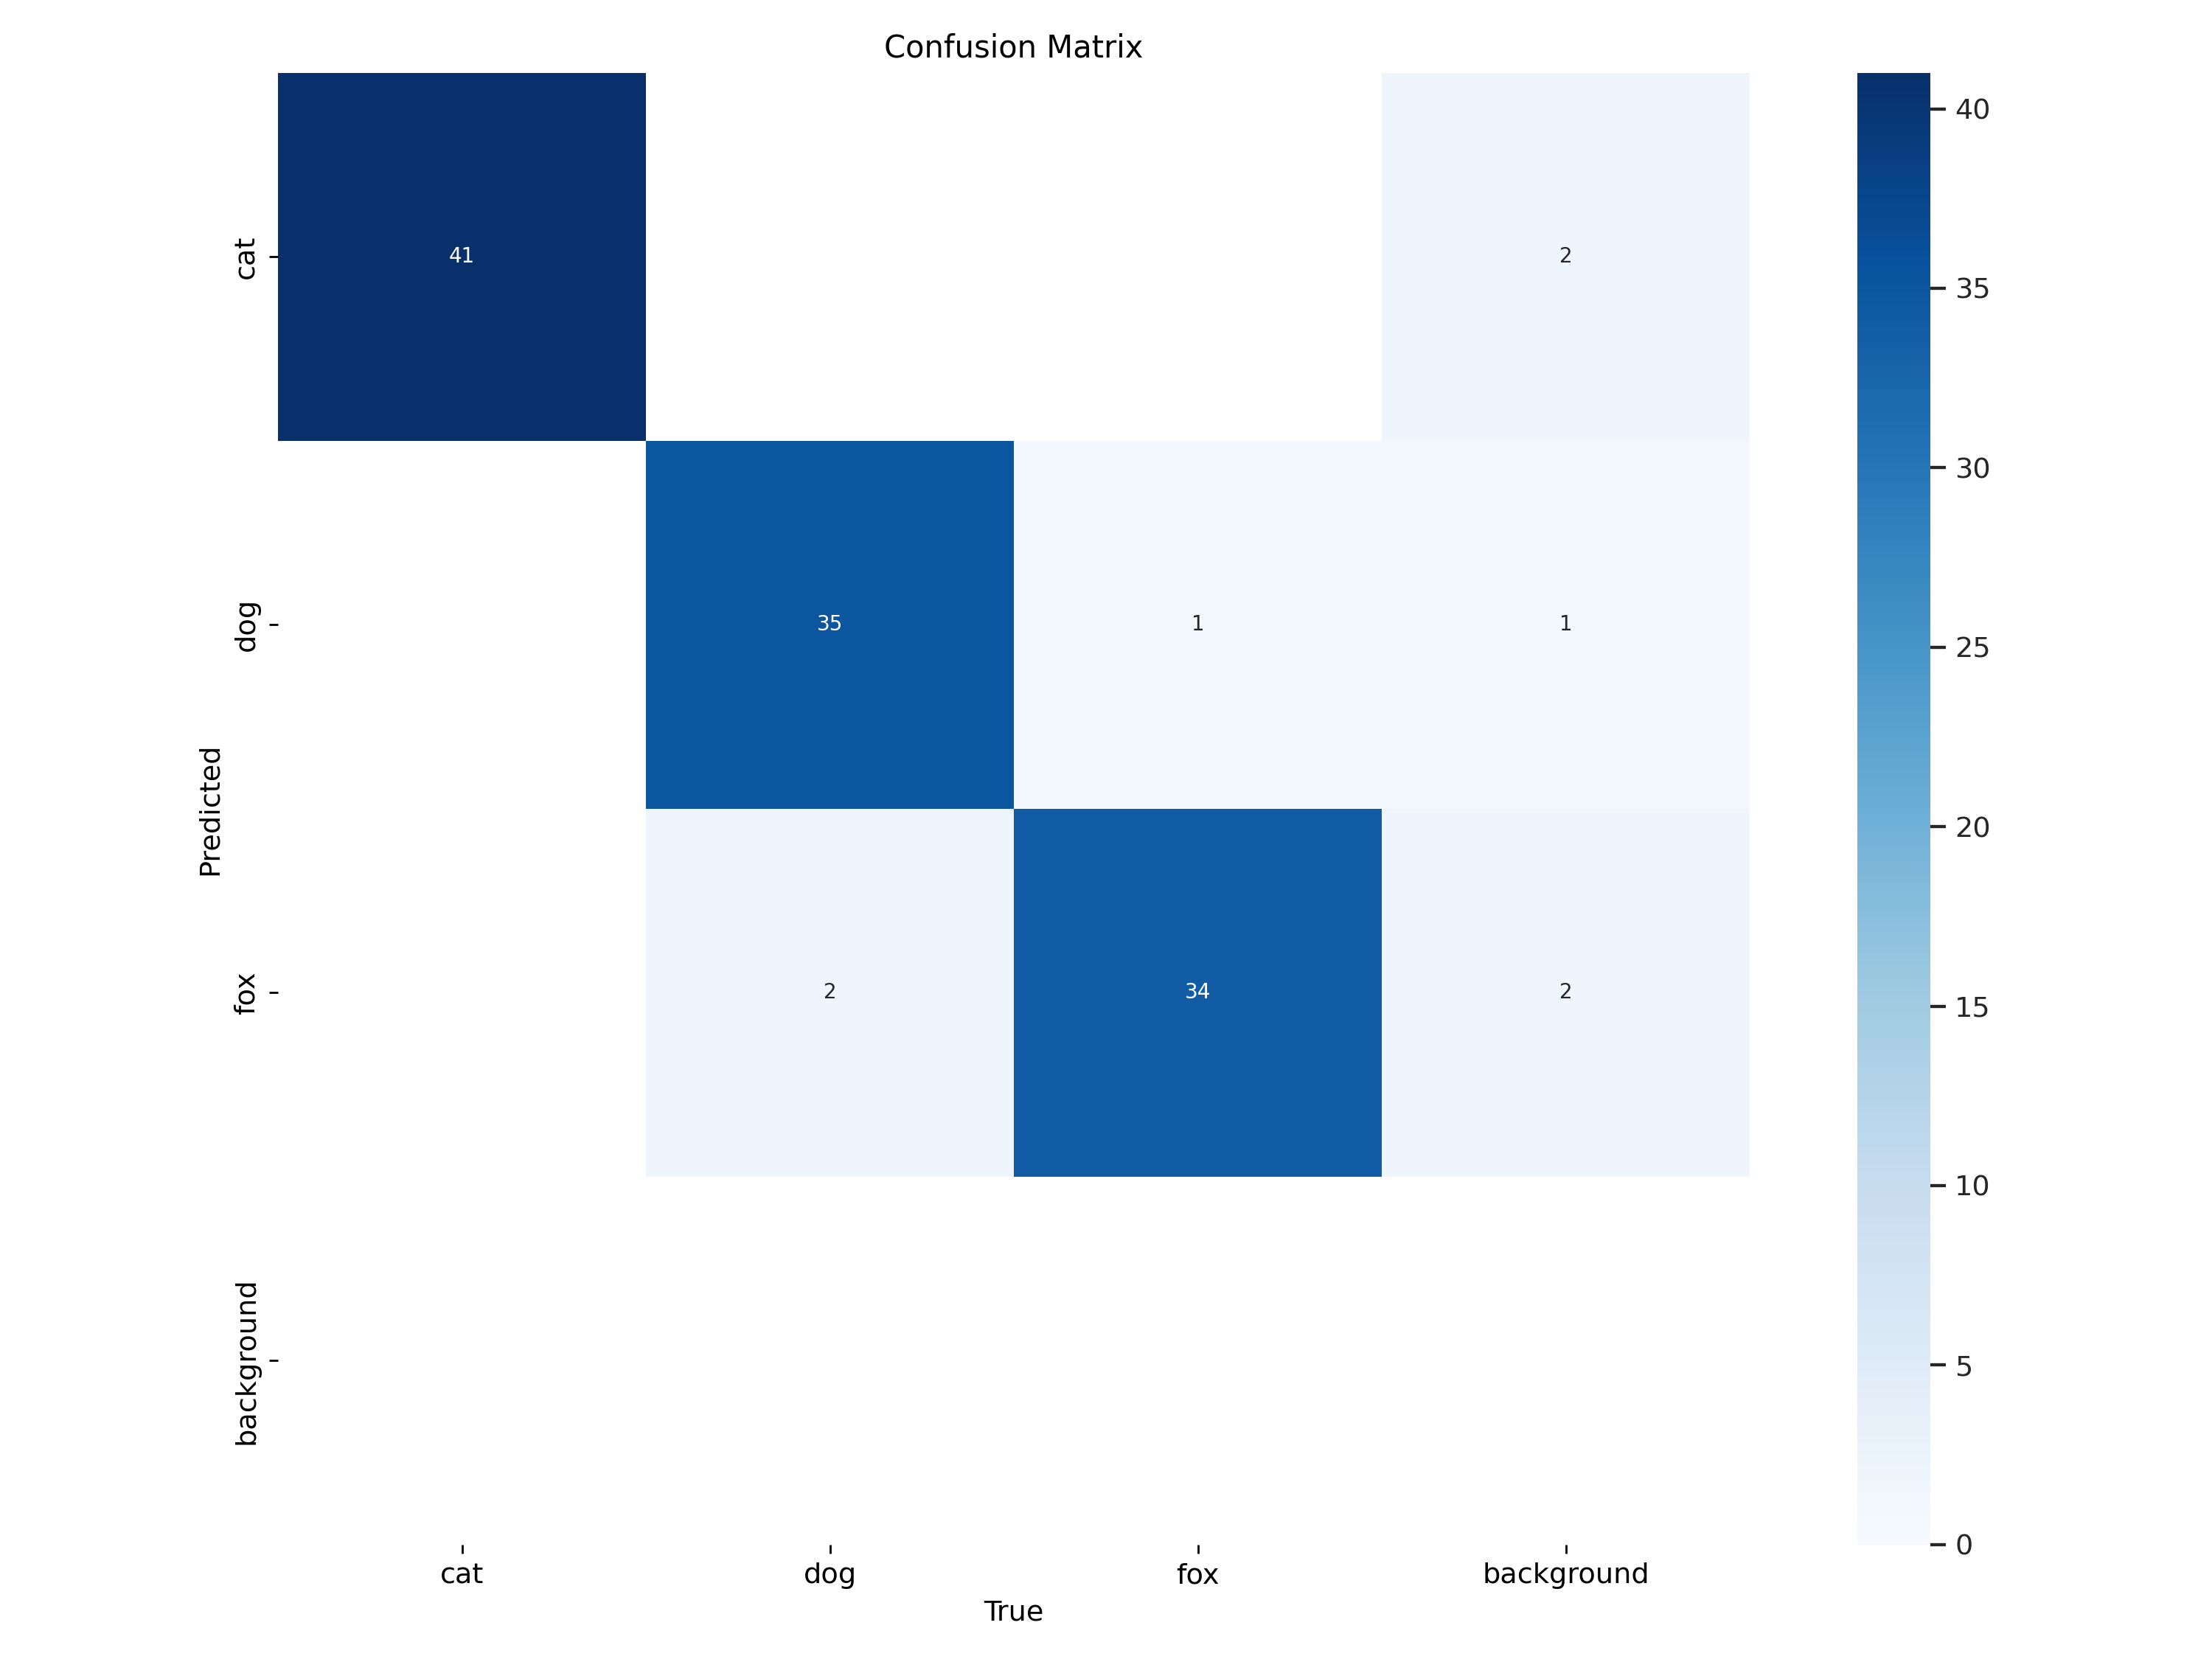

In [11]:
from IPython.display import display, Image
Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

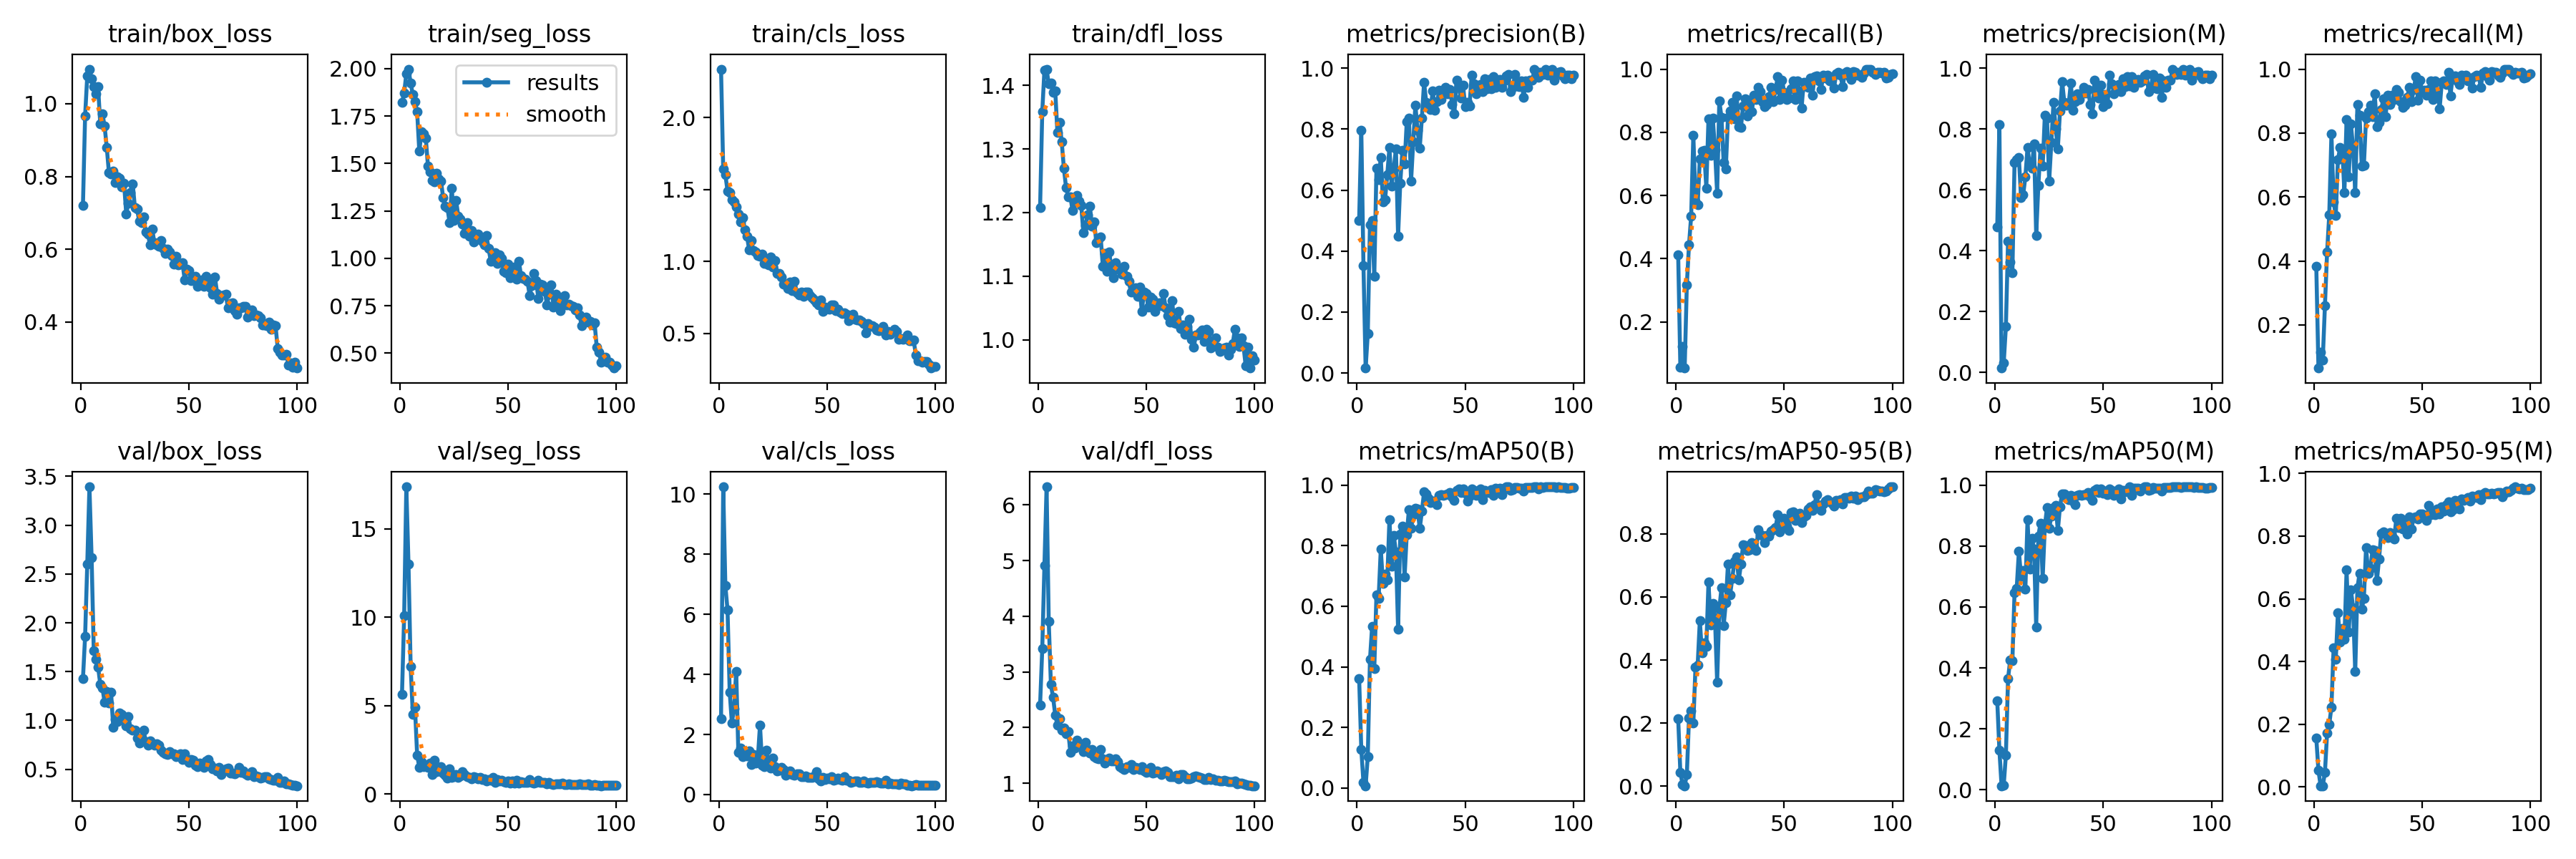

In [12]:
Image(filename=f'{HOME}/runs/segment/train/results.png', width=600)

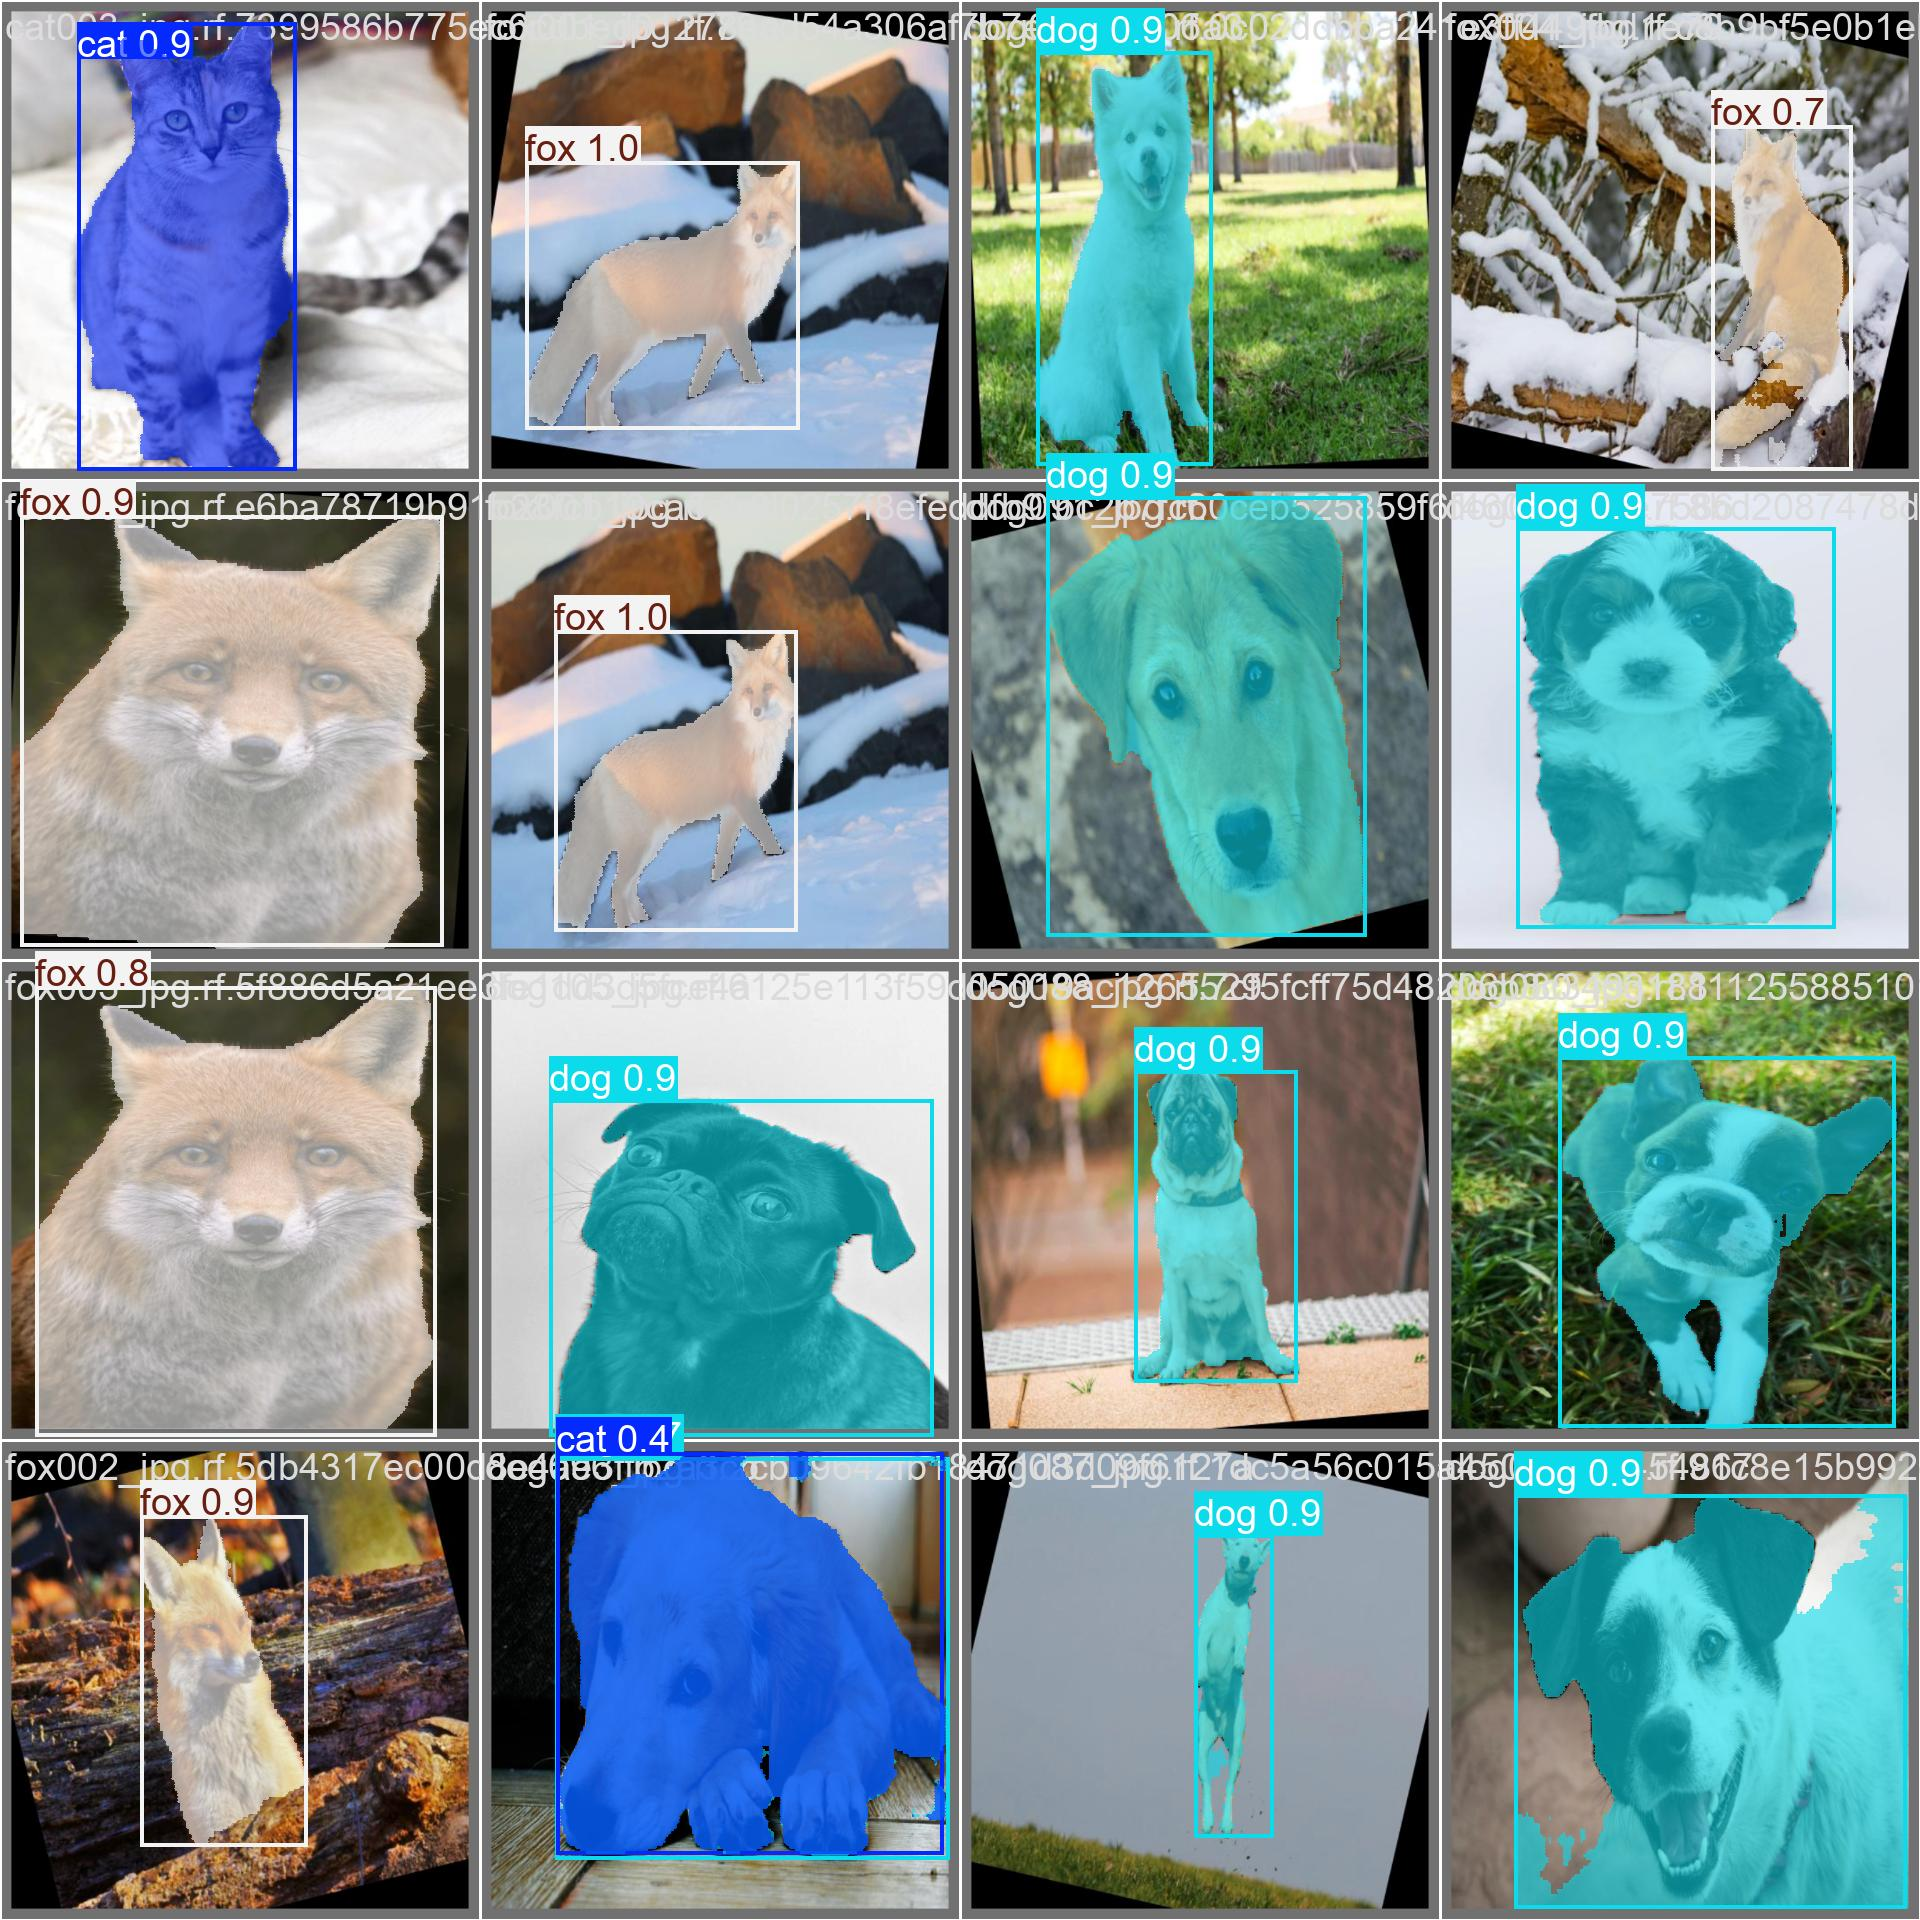

In [13]:
Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

# Validate the Model

You can use the YOLO CLI to validate the model on a validation set. This will give you the mAP score for the model.

In [15]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data=$yaml_path

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,977 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        111        113      0.977      0.986      0.993      0.946      0.977      0.986      0.993      0.954
                   cat         40         41      0.985          1      0.995      0.942      0.985          1      0.995      0.959
                   dog         36         37      0.973      0.962      0.993       0.95      0.973      0.962      0.993      0.948
                   fox         35         35      0.972      0.998       0.99      0.944      0.972      0.998       0.99      0.955
Speed: 1.0ms preprocess, 6.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/val
💡

## Inference on the Test Set

You can use the YOLO CLI to run inference on the test set. This will give you the predictions for the test set and we can visualize them here.

In [20]:
!yolo predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source=$dataset_path/test/images save=True

Ultralytics 8.3.82 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 15950MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,977 parameters, 0 gradients, 35.3 GFLOPs

image 1/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat013_jpeg.rf.70509d2d6f12bfe306e4058777d54418.9f80c4d4f1df.6453dc9d622e.jpg: 640x640 1 cat, 4.2ms
image 2/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat013_jpeg.rf.86af9b5c5c817498f4a8fde3a9c037a4.4daaddff855d.b43dfc91eeb3.jpg: 640x640 1 cat, 4.6ms
image 3/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat025_jpg.rf.a6479cd5c378d8843b4be368c83deaf7.5de643f4aba1.bbc9f9a56ae3.jpg: 640x640 1 cat, 4.1ms
image 4/110 /home/pyrat/projects/training-notebooks/notebooks/dogs-cats-foxes-yolo-2/test/images/cat026_jpg.rf.4f821550714df692d9a90b1b1758e5c8.a4bfd6a1a0f2.a62ea8e7cecb.jpg: 640x640 1 cat, 4.1ms
image 5/110 /home/pyrat/

## Visualize the Predictions

Lets look at some of the predictions made by the model on the test set.

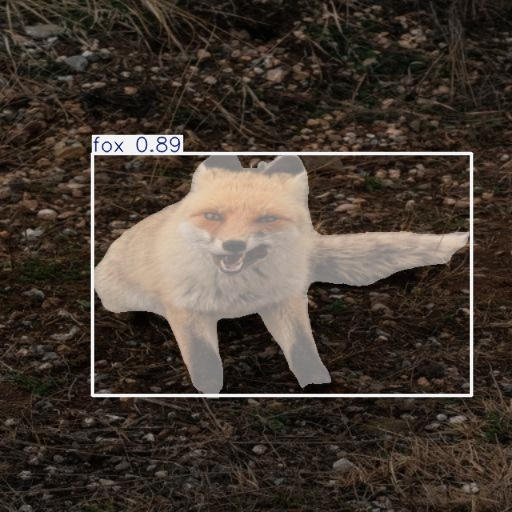

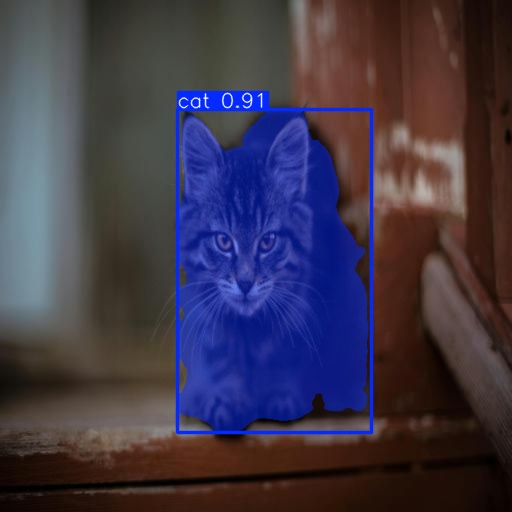

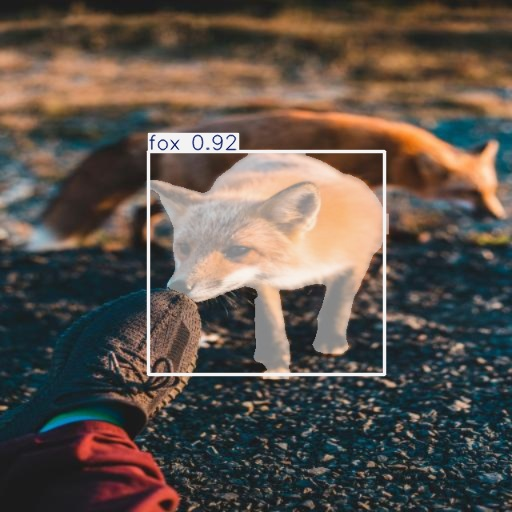

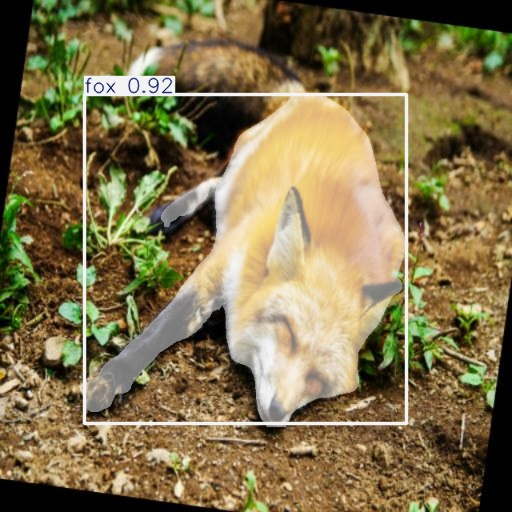

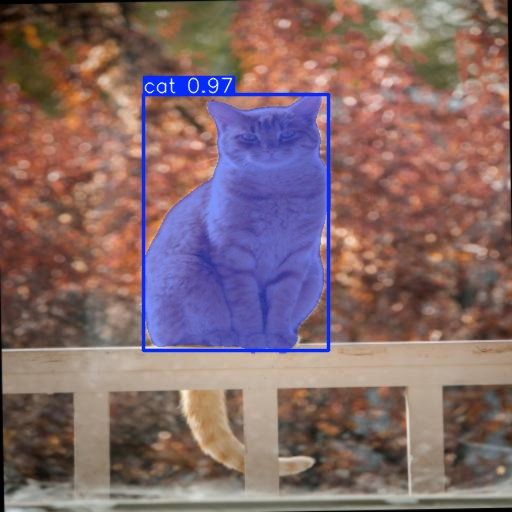

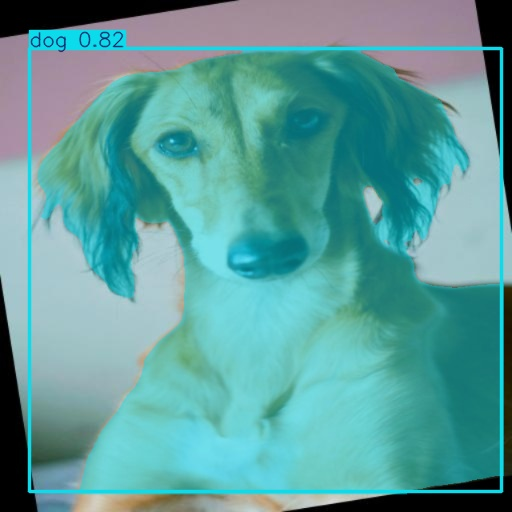

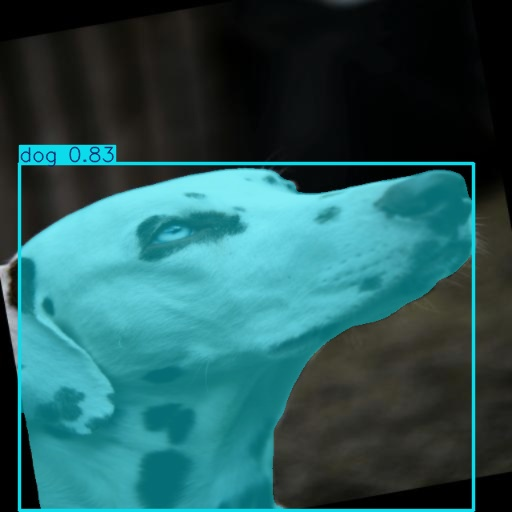

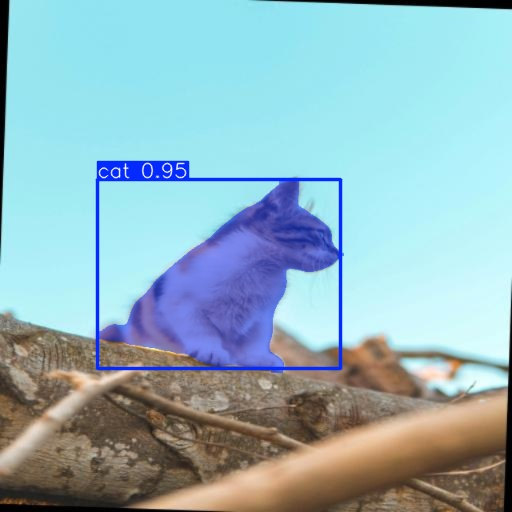

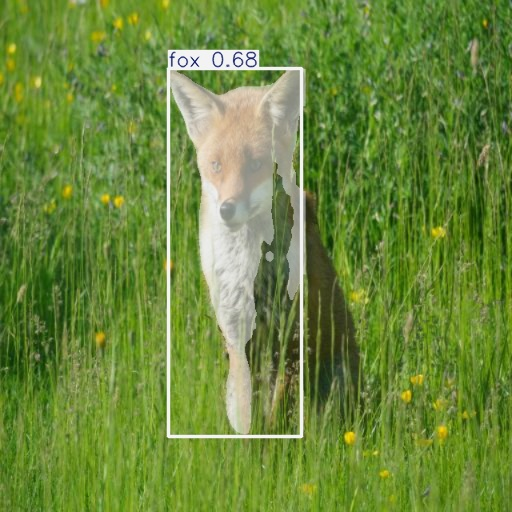

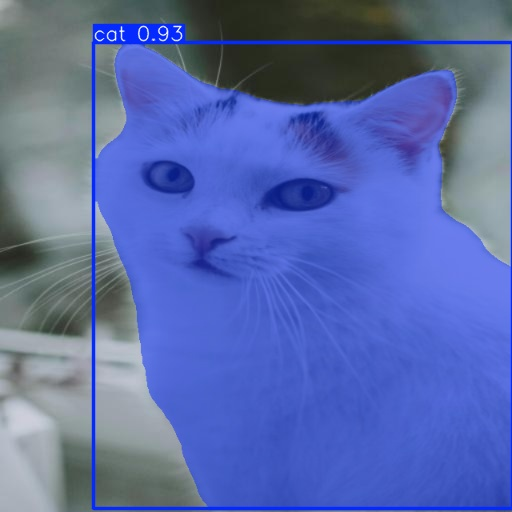

In [21]:
import glob
import random

from IPython.display import Image, display

# Get all image paths
image_paths = glob.glob(f'{HOME}/runs/segment/predict/*.jpg')

# Select up to 20 random images
random_images = random.sample(image_paths, min(len(image_paths), 10))

# Display the selected images
for image_path in random_images:
    display(Image(filename=image_path, width=600))

## Conclusion

This notebook is a simple example of how to train a YOLOv11 segmentation model using the Ultralytics library. You can use this as a starting point for your own projects.

The model is trained on the exported dataset from Oslo and the results are visualized. 

You can find the model weights and the training results in the `runs` folder. Generally `best.pt` is the best model and `results.png` gives you information on how the training went.